In [ ]:
!unzip /content/drive/MyDrive/ARVhackathon/Data/super-ai-engineer-2021-house-grade-classification.zip -d /content/house-grade/

Archive:  /content/drive/MyDrive/ARVhackathon/Data/super-ai-engineer-2021-house-grade-classification.zip
  inflating: /content/house-grade/grade.csv  
  inflating: /content/house-grade/sample_submission.csv  
  inflating: /content/house-grade/test.zipfile  
  inflating: /content/house-grade/test/004c4789.jpg  
  inflating: /content/house-grade/test/00e2bfe0.jpg  
  inflating: /content/house-grade/test/01265567.jpg  
  inflating: /content/house-grade/test/0188f57d.jpg  
  inflating: /content/house-grade/test/01945b53.jpg  
  inflating: /content/house-grade/test/01ccbb76.jpg  
  inflating: /content/house-grade/test/0272a96c.jpg  
  inflating: /content/house-grade/test/034c3c52.jpg  
  inflating: /content/house-grade/test/03df66ca.jpg  
  inflating: /content/house-grade/test/04dd10ad.jpg  
  inflating: /content/house-grade/test/05a12031.jpg  
  inflating: /content/house-grade/test/05f824ae.jpg  
  inflating: /content/house-grade/test/06683f95.jpg  
  inflating: /content/house-grade/test/0

# Prepare Data

In [ ]:
import pandas as pd
meta_df = pd.read_csv('/content/house-grade/train.csv')

In [ ]:
import os
import numpy as np

In [ ]:
train_id = []
train_full_path = []
train_path = "/content/house-grade/train"
for im in os.listdir(train_path):
  train_id.append(im)
  train_full_path.append(train_path + '/' + im)

In [ ]:
path_meta = pd.DataFrame(columns=["image_name", "path"])
path_meta["image_name"] = train_id
path_meta["path"] = train_full_path

In [ ]:
metadata = pd.merge(meta_df, path_meta, on="image_name", how="left")

In [ ]:
metadata.head()

,image_name,class,path
0,ChokChai4_img_13-7956791_100-6031267_a187-2159...,0,/content/house-grade/train/ChokChai4_img_13-79...
1,ChokChai4_img_13-7961753_100-6031881_a185-9785...,0,/content/house-grade/train/ChokChai4_img_13-79...
2,ChokChai4_img_13-7969811_100-5906061_a180-5812...,0,/content/house-grade/train/ChokChai4_img_13-79...
3,ChokChai4_img_13-7970811_100-5906071_a180-5812...,0,/content/house-grade/train/ChokChai4_img_13-79...
4,ChokChai4_img_13-7971811_100-5906081_a180-5812...,0,/content/house-grade/train/ChokChai4_img_13-79...


In [ ]:
# create Class 1 folder
os.mkdir('./class_1')

In [ ]:
class1_path_list = metadata[metadata['class'] == 1]['path'].tolist()

In [ ]:
# copy to folder
import shutil
path = '/content/class_1/'
for img in class1_path_list:
  #print(img.split('/')[-1])
  shutil.copy(img,path+img.split('/')[-1])
  #break

In [ ]:
!zip -r /content/class1.zip /content/class_1

  adding: content/class_1/ (stored 0%)
  adding: content/class_1/img_13-8001002_100-577015_a170-2816838_s80-2816838_y0_f90_1.jpg (deflated 0%)
  adding: content/class_1/img_13-8242995_100-5829072_a2-971170788_s272-971170788_y0_f90_1.jpg (deflated 1%)
  adding: content/class_1/img_13-7952184_100-5770407_a265-3994986_s175-39949860000002_y0_f90_1.jpg (deflated 0%)
  adding: content/class_1/img_13-7838052_100-5843975_a187-3439031_s277-34390310000003_y0_f90_1.jpg (deflated 1%)
  adding: content/class_1/img_13-8284902_100-6002345_a177-1553042_s87-15530419999999_y0_f90_1.jpg (deflated 1%)
  adding: content/class_1/img_13-839449_100-6021847_a165-1185621_s75-11856209999996_y0_f90_1.jpg (deflated 1%)
  adding: content/class_1/MrtSutthisan_img_13-7973554_100-5706212_a256_s270_y75_f90_0.jpg (deflated 0%)
  adding: content/class_1/img_13-8177802_100-5900508_a83-13884175_s353-13884175_y0_f90_1.jpg (deflated 1%)
  adding: content/class_1/img_13-8437378_100-5470695_a57-38785231_s147-38785231_y0_f90_1.

# Start GAN!

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
GENERATE_RES = 7 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/class_1'
EPOCHS = 1000
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 224px square images.


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).convert('RGB').resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)


Looking for file: /content/class_1/training_data_224_224.npy
Loading training images...


100%|██████████| 39/39 [00:00<00:00, 40.63it/s]

Saving training image binary...
Image preprocess time: 0:00:01.00


In [ ]:
training_data[0].shape

(224, 224, 3)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (21, 21), strides=(2, 2), padding='valid', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (28, 28), strides=(2, 2), padding='valid', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (42, 42), strides=(2, 2), padding='valid', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 28, 28, 3)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 33, 33, 128)      14450688  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 33, 33, 128)      5

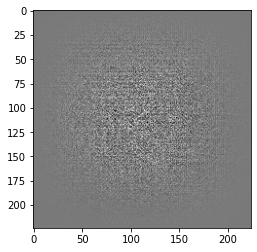

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
discriminator.summary()

In [ ]:
decision = discriminator(generated_image)
print (decision)

In [ ]:

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:

import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 1000
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:

import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

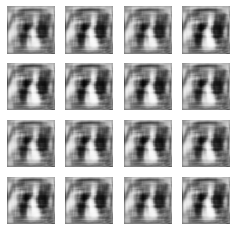

In [ ]:
train(train_dataset, EPOCHS)